In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy

In [2]:
df_review = pd.read_csv("yelp_academic_dataset_review.csv")
df_review = pd.DataFrame(df_review)

In [3]:
df_business = pd.read_csv("yelp_academic_dataset_business.csv")
df_business = pd.DataFrame(df_business)

In [4]:
df_user = pd.read_csv("yelp_academic_dataset_user.csv")
df_user = pd.DataFrame(df_user)

In [5]:
df_review

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
6990275,H0RIamZu0B0Ei0P4aeh3sQ,qskILQ3k0I_qcCMI-k6_QQ,jals67o91gcrD4DC81Vk6w,5.0,1,2,1,Latest addition to services from ICCU is Apple...,2014-12-17 21:45:20
6990276,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5.0,2,1,2,"This spot offers a great, affordable east week...",2021-03-31 16:55:10
6990277,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4.0,1,0,0,This Home Depot won me over when I needed to g...,2019-12-30 03:56:30
6990278,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5.0,1,0,0,For when I'm feeling like ignoring my calorie-...,2022-01-19 18:59:27


In [6]:
df_business=df_business[df_business['city']=='Philadelphia']
df_business = df_business[(df_business["categories"].str.contains('Restaurants', na=False)) & (df_business['is_open']==1)].reset_index(drop=True)

# Filtrar as avaliações para apenas aquelas cujo 'business_id' está presente no df_business
df_merged = df_review[df_review['business_id'].isin(df_business['business_id'])]


In [7]:
#depois de selecionar apenas reviews de restaurantes em philadelphia
print(f'Number of users: {df_merged["user_id"].nunique()}')
print(f'Number of businesses: {df_merged["business_id"].nunique()}')

Number of users: 178325
Number of businesses: 3525


In [9]:
df_limited = df_merged[df_merged['user_id'].isin(df_merged['user_id'].unique()[:5000]) &
                    df_merged['business_id'].isin(df_merged['business_id'].unique()[:100000])]
df_limited.reset_index(drop=True, inplace=True)

In [10]:
# Creating dataset from the df_review
reader = Reader(rating_scale=(df_limited.stars.min(), df_limited.stars.max()))
data = Dataset.load_from_df(df_limited[['user_id', 'business_id', 'stars']], reader)

# Train/test split
trainset, testset = train_test_split(data, test_size=0.2)

In [8]:
df_merged.shape

(511138, 9)

In [11]:
def evaluate_precision_recall(predictions, threshold=3.5):
    # Convert predictions to a binary format based on the threshold
    y_true = []
    y_pred = []

    # Count relevant items for precision and recall
    for uid, iid, true_r, est, _ in predictions:
        # Treat predictions >= threshold as relevant (1), otherwise not relevant (0)
        y_true.append(1 if true_r >= threshold else 0)
        y_pred.append(1 if est >= threshold else 0)

    # Calculate True Positives, False Positives, False Negatives
    true_positives = sum((1 for t, p in zip(y_true, y_pred) if t == 1 and p == 1))
    false_positives = sum((1 for t, p in zip(y_true, y_pred) if t == 0 and p == 1))
    false_negatives = sum((1 for t, p in zip(y_true, y_pred) if t == 1 and p == 0))

    # Calculate Precision and Recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

def evaluate_coverage(predictions, total_items): #I THINK THIS IS WRONG
    # Get the set of unique items recommended
    recommended_items = set(pred[1] for pred in predictions)  # pred[1] is the business_id
    coverage = len(recommended_items) / total_items if total_items > 0 else 0
    return coverage

In [23]:
def evaluate_algorithm(algo, trainset, testset):
    algo.fit(trainset)
    predictions = algo.test(testset)

    rmse = accuracy.rmse(predictions)

    precision, recall = evaluate_precision_recall(predictions)

    return {
        "RMSE": rmse,
        "Precision": precision,
        "Recall": recall,
    }

In [13]:
total_items = df_business['business_id'].nunique()  # Total number of unique businesses
random_algo = NormalPredictor()
evaluation_results = evaluate_algorithm(random_algo, trainset, testset, total_items)
print(evaluation_results)

RMSE: 1.4348
{'RMSE': 1.4348288963798275, 'Precision': 0.7047015886646629, 'Recall': 0.6313107029522069, 'Coverage': 0.6093617021276596}


In [14]:
algorithms = {
    "random": NormalPredictor(),
    "ubcf_msd": KNNBasic(sim_options={'user_based': True}),
    "ubcf_cosine": KNNBasic(sim_options={'user_based': True, 'name':"cosine"}),    
    "ibcf_msd": KNNBasic(sim_options={'user_based': False}),
    "ibcf_cosine": KNNBasic(sim_options={'user_based': False, 'name':"cosine"}),
    "svd_algo": SVD()
}

In [15]:
results = []

for name, algo in algorithms.items():
    metrics = evaluate_algorithm(algo, trainset, testset, total_items)
    metrics['Algorithm'] = name  # Add the algorithm name for reference
    results.append(metrics)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display results
print(results_df)

RMSE: 1.4468
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0560
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0594
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0777
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0862
RMSE: 0.9926
       RMSE  Precision    Recall  Coverage    Algorithm
0  1.446787   0.699871  0.627657  0.609362       random
1  1.056034   0.746258  0.872488  0.609362     ubcf_msd
2  1.059358   0.744508  0.873449  0.609362  ubcf_cosine
3  1.077717   0.740666  0.881335  0.609362     ibcf_msd
4  1.086190   0.735035  0.880854  0.609362  ibcf_cosine
5  0.992609   0.767882  0.863064  0.609362     svd_algo


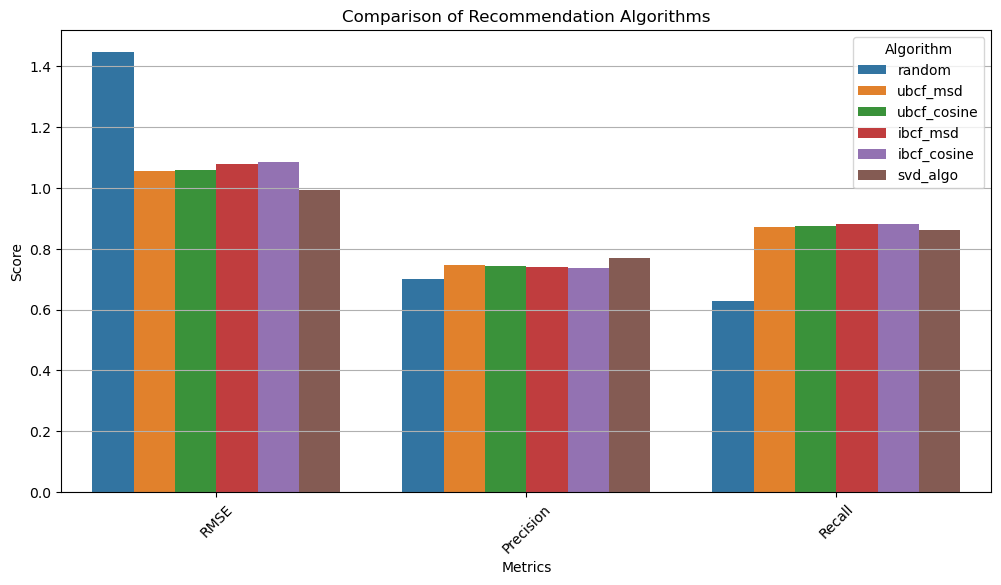

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

results_melted = results_df.melt(id_vars='Algorithm', value_vars=['RMSE', 'Precision', 'Recall'])#, 'Coverage'

plt.figure(figsize=(12, 6))
plt.grid()
sns.barplot(data=results_melted, x='variable', y='value', hue='Algorithm')
plt.title('Comparison of Recommendation Algorithms')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.xticks(rotation=45)
plt.legend(title='Algorithm')
plt.show()

In [28]:
from surprise import accuracy
import pandas as pd

# Function to get predictions for a model
def get_predictions(algo, testset):
    return algo.test(testset)

# Store predictions for each algorithm
predictions_dict = {}

for name, algo in algorithms.items():
    algo.fit(trainset)  # Train the algorithm
    predictions = get_predictions(algo, testset)
    predictions_dict[name] = predictions

# Prepare a DataFrame to store the actual and predicted ratings
comparison_data = []

for name, predictions in predictions_dict.items():
    for uid, iid, true_r, est, _ in predictions:
        comparison_data.append({
            "User ID": uid,
            "Business ID": iid,
            "True Rating": true_r, 
            "Predicted Rating": round(est), #round(est)
            "Model": name
        })

comparison_df = pd.DataFrame(comparison_data)
# Calculate RMSE for each model
results = {}

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


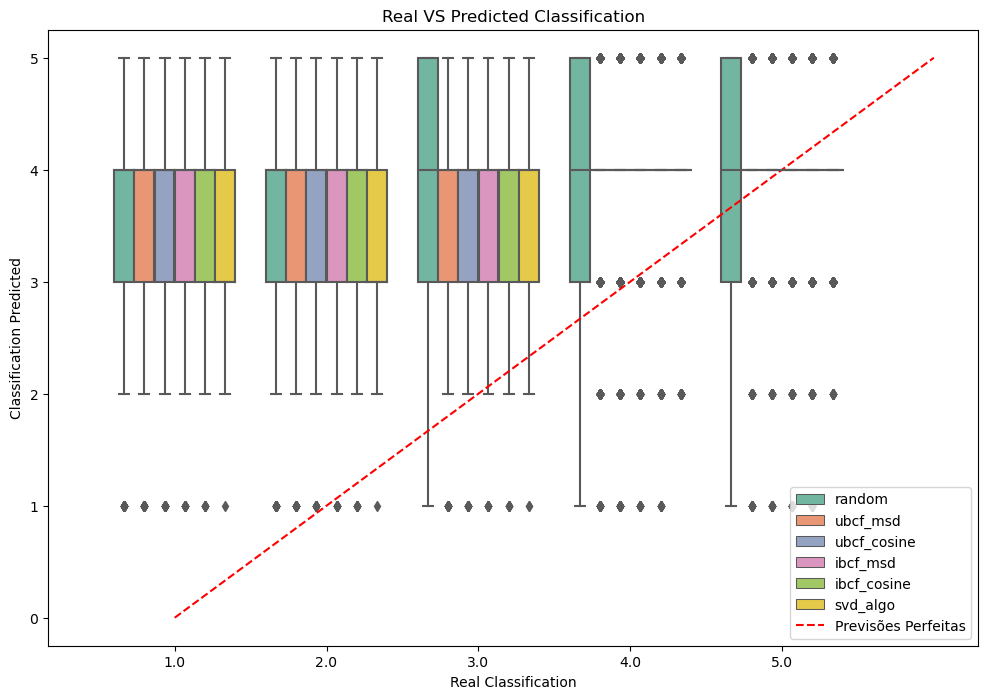

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crie o box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=comparison_df, x='True Rating', y='Predicted Rating', hue='Model', palette='Set2')

# Adicionar linha de previsões perfeitas
plt.plot([0, 5], [0, 5], color='red', linestyle='--', label='Previsões Perfeitas')  # Linha para previsões perfeitas
plt.xlabel('Real Classification')
plt.ylabel('Classification Predicted')
plt.title('Real VS Predicted Classification')
plt.legend()
plt.show()



algorithms = {
    "random": NormalPredictor(),
    "ubcf_msd": KNNBasic(sim_options={'user_based': True}),
    "ubcf_cosine": KNNBasic(sim_options={'user_based': True, 'name':"cosine"}),    
    "ibcf_msd": KNNBasic(sim_options={'user_based': False}),
    "ibcf_cosine": KNNBasic(sim_options={'user_based': False, 'name':"cosine"}),
    "svd_algo": SVD()
}

Recall & Prediction @K , adapted by Lara from
from  https://surprise.readthedocs.io/en/stable/FAQ.html

In [17]:
from collections import defaultdict

from surprise import Dataset, SVD
from surprise.model_selection import KFold


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


kf = KFold(n_splits=5)

algorithms2 = {
    "random": NormalPredictor(),
    "ubcf_msd": KNNBasic(sim_options={'user_based': True}),
    "ubcf_cosine": KNNBasic(sim_options={'user_based': True, 'name':"cosine"}),    
    "ibcf_msd": KNNBasic(sim_options={'user_based': False}),
    "ibcf_cosine": KNNBasic(sim_options={'user_based': False, 'name':"cosine"}),
    "svd_algo": SVD()
}
algo_names = []
precision_values = []
recall_values = []

# total_precision = 0
# total_recall = 0
# n_folds = kf.n_splits

# for trainset, testset in kf.split(data):
#     algo.fit(trainset)
#     predictions = algo.test(testset)
#     precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

#     # Precision and recall can then be averaged over all users
#     fold_precision = sum(prec for prec in precisions.values()) / len(precisions)
#     fold_recall = sum(rec for rec in recalls.values()) / len(recalls)

#     total_precision += fold_precision
#     total_recall += fold_recall

# # Final precision and recall (averaged across all folds)
# final_precision = total_precision / n_folds
# final_recall = total_recall / n_folds

# # Display final results
# print(f'Average Precision@K across all folds: {final_precision:.4f}')
# print(f'Average Recall@K across all folds: {final_recall:.4f}')^


# Evaluate each algorithm
for algo_name, algo in algorithms.items():
    print(f"Evaluating {algo_name}...")

    total_precision = 0
    total_recall = 0
    n_folds = kf.n_splits

    # Loop through each fold
    for trainset, testset in kf.split(data):
        algo.fit(trainset)  # Train the model on the training set
        predictions = algo.test(testset)  # Generate predictions on the test set
        
        # Calculate precision and recall for this fold
        precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4)
        
        # Average precision and recall over all users for this fold
        fold_precision = sum(prec for prec in precisions.values()) / len(precisions)
        fold_recall = sum(rec for rec in recalls.values()) / len(recalls)
        
        # Accumulate the fold precision and recall
        total_precision += fold_precision
        total_recall += fold_recall

    # Final precision and recall (averaged across all folds)
    final_precision = total_precision / n_folds
    final_recall = total_recall / n_folds

    # Store results for plotting
    algo_names.append(algo_name)
    precision_values.append(final_precision)
    recall_values.append(final_recall)

    # Display final results for this algorithm
    print(f'{algo_name} - Average Precision@K: {final_precision:.4f}')
    print(f'{algo_name} - Average Recall@K: {final_recall:.4f}')
    print('-' * 40)

Evaluating random...
random - Average Precision@K: 0.5095
random - Average Recall@K: 0.3891
----------------------------------------
Evaluating ubcf_msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
ubcf_msd - Average Precision@K: 0.5292
ubcf_msd - Average Recall@K: 0.3953
----------------------------------------
Evaluating ubcf_cosine...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity m

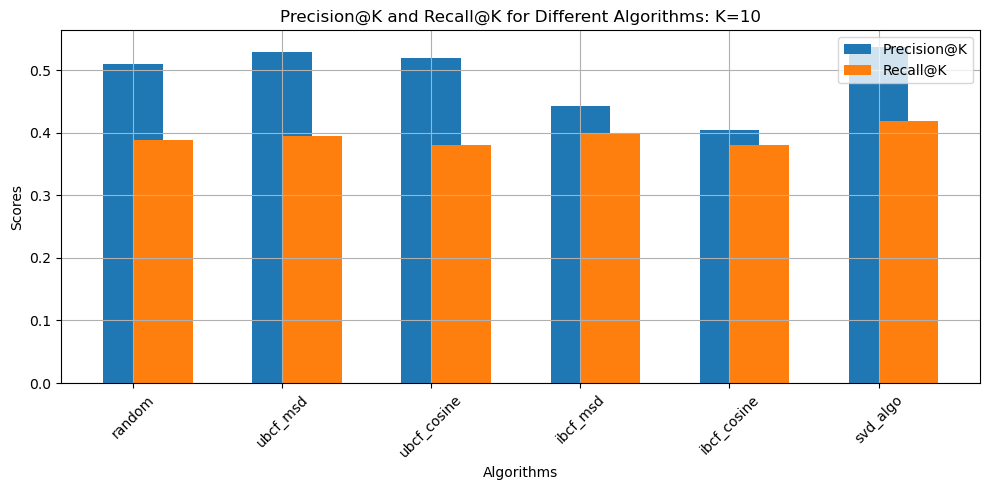

In [18]:
plt.figure(figsize=(10, 5))
plt.grid()
# Plot precision
plt.bar(algo_names, precision_values, width=0.4, label="Precision@K", align='center')

# Plot recall
plt.bar(algo_names, recall_values, width=0.4, label="Recall@K", align='edge')

# Adding labels and title
plt.xlabel("Algorithms")
plt.ylabel("Scores")
plt.title("Precision@K and Recall@K for Different Algorithms: K=10")
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

Agora vou dividir entre users frequentes e users não frequentes. (Vou dividir a nível de users porque parece ser o que está a ter melhor precision e recall @ k =10)

Vou usar KNNBasic(sim_options={'user_based': True}),  por ser o melhor no gráfico de cima

In [48]:
from collections import defaultdict
import pandas as pd
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import KFold

# Assuming df_merged is your DataFrame with user and business interactions
# Step 1: Count user frequencies
user_counts = df_merged['user_id'].value_counts()

# Step 2: Select top and bottom 10% users
num_users = len(user_counts)
top_10_percent_count = int(num_users * 0.1)
bottom_10_percent_count = int(num_users * 0.1)

top_users = user_counts.nlargest(top_10_percent_count).index.tolist()
bottom_users = user_counts.nsmallest(bottom_10_percent_count).index.tolist()

# Step 3: Create datasets for top and bottom users
df_top_users = df_merged[df_merged['user_id'].isin(top_users)]
df_bottom_users = df_merged[df_merged['user_id'].isin(bottom_users)]

# Reset index for both DataFrames
df_top_users.reset_index(drop=True, inplace=True)
df_bottom_users.reset_index(drop=True, inplace=True)

# Step 4: Define the function to calculate precision and recall at k
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user."""
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

# Step 5: Function to evaluate precision and recall for a dataset
def evaluate_precision_recall(data):
    kf = KFold(n_splits=5)
    algo = KNNBasic(sim_options={'user_based': True})  # Change the algorithm as needed

    total_precision = 0
    total_recall = 0
    n_folds = kf.n_splits

    for trainset, testset in kf.split(data):
        algo.fit(trainset)  # Train the model
        predictions = algo.test(testset)  # Generate predictions

        precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
        
        fold_precision = sum(prec for prec in precisions.values()) / len(precisions)
        fold_recall = sum(rec for rec in recalls.values()) / len(recalls)

        total_precision += fold_precision
        total_recall += fold_recall

    final_precision = total_precision / n_folds
    final_recall = total_recall / n_folds
    
    return final_precision, final_recall

# Step 6: Convert DataFrames to Surprise Dataset format
def create_surprise_dataset(df):
    reader = Reader(rating_scale=(1, 5))  # Adjust the rating scale based on your dataset
    return Dataset.load_from_df(df[['user_id', 'business_id', 'stars']], reader=reader)

# Evaluate top users
top_users_dataset = create_surprise_dataset(df_top_users)
top_users_precision, top_users_recall = evaluate_precision_recall(top_users_dataset)

# Evaluate bottom users
bottom_users_dataset = create_surprise_dataset(df_bottom_users)
bottom_users_precision, bottom_users_recall = evaluate_precision_recall(bottom_users_dataset)

# Print results
print("Top 10% Frequent Users:")
print(f'Average Precision@K: {top_users_precision:.4f}')
print(f'Average Recall@K: {top_users_recall:.4f}')

print("\nBottom 10% Less Frequent Users:")
print(f'Average Precision@K: {bottom_users_precision:.4f}')
print(f'Average Recall@K: {bottom_users_recall:.4f}')


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Top 10% Frequent Users:
Average Precision@K: 0.5922
Average Recall@K: 0.4491

Bottom 10% Less Frequent Users:
Average Precision@K: 0.0000
Average Recall@K: 0.0000


In [24]:
# User-Based Collaborative Filtering
ubcf_algo = KNNBasic(sim_options={'user_based': True})
ubcf_rmse = evaluate_algorithm(ubcf_algo, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0541


In [95]:
# Item-Based Collaborative Filtering
ibcf_algo = KNNBasic(sim_options={'user_based': False})
ibcf_rmse = evaluate_algorithm(ibcf_algo, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0824


In [96]:
# Singular Value Decomposition (SVD)
svd_algo = SVD()
svd_rmse = evaluate_algorithm(svd_algo, trainset, testset)

RMSE: 1.0019


In [97]:
print(f"Random RMSE: {random_rmse:.3f}")
print(f"User-Based CF RMSE: {ubcf_rmse:.3f}")
print(f"Item-Based CF RMSE: {ibcf_rmse:.3f}")
print(f"SVD RMSE: {svd_rmse:.3f}")

Random RMSE: 1.479
User-Based CF RMSE: 1.055
Item-Based CF RMSE: 1.082
SVD RMSE: 1.002
